In [1]:
import sys
from utils.helper import preprocess_runs

path_name_dict = {
    'JOB-Light': 'JOB-light.json',
    'JOB': 'JOB.json',
    'JOB-Complex': 'JOB-Complex.json'
}
benchmark_stats_dict = preprocess_runs(json_path='workload_runs',path_name_dict=path_name_dict)

Loading run files from workload_runs
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:04<00:00, 32.20it/s]


Benchmark: JOB (37085 plans)


Cleaning SQL: 100%|██████████| 37085/37085 [00:06<00:00, 5966.05it/s]


Benchmark: JOB-Complex (18479 plans)


Cleaning SQL: 100%|██████████| 18479/18479 [00:00<00:00, 67367.47it/s]


# PG Cost Est Analysis

Benchmark      Pearson    Spearman
-----------  ---------  ----------
JOB-Light     0.288351    0.894182
JOB           0.219348    0.432089
JOB-Complex   0.40956     0.270613


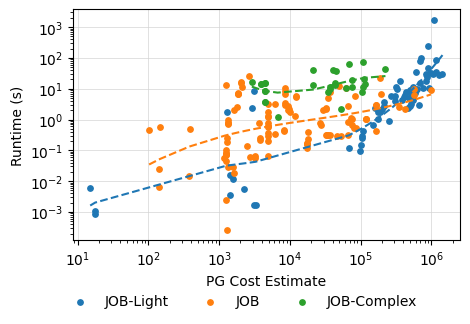

In [2]:
import scipy
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np
import tabulate


def get_pg_cost_est(plan: Dict):
    """
    Get the cost estimate from the plan.
    """
    if 'Plan' in plan:
        return get_pg_cost_est(plan['Plan'])
    if 'Total Cost' in plan:
        return plan['Total Cost']
    return 0


pg_cost_series = dict()

for benchmark_name, info in benchmark_stats_dict.items():
    pg_cost_est_list = []
    for id, (sql, plan_info) in enumerate(info.items()):
        pg_plan = plan_info['pg_plan']
        pg_runtime = plan_info['pg_runtime'] / 1000  # convert to s
        pg_cost_est_list.append((pg_runtime, get_pg_cost_est(pg_plan)))

    pg_cost_series[benchmark_name] = pg_cost_est_list

# create a scatter plot

# create a scatter plot with different benchmarks as different series
plt.figure(figsize=(5, 3))

tabulate_rows = []
for benchmark_name, pg_cost_est_list in pg_cost_series.items():
    runtimes, costs = zip(*pg_cost_est_list)
    plt.scatter(costs, runtimes, label=benchmark_name, s=15)

    # Add a trend line
    z = np.polyfit(np.log(costs), np.log(runtimes), 3)
    p = np.poly1d(z)
    sorted_costs = np.sort(costs)
    plt.plot(sorted_costs, np.exp(p(np.log(sorted_costs))), linestyle='--')

    # compute correlation between cost and runtime
    pearson = scipy.stats.pearsonr(costs, runtimes)[0]
    spearman = scipy.stats.spearmanr(costs, runtimes)[0]
    tabulate_rows.append([benchmark_name, pearson, spearman])

plt.xlabel('PG Cost Estimate')
plt.ylabel('Runtime (s)')
# plt.title('PG Cost Estimate vs Runtime')
plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.05, -0.18), frameon=False)
plt.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

plt.savefig('tmp/cost_vs_runtimes.pdf', bbox_inches='tight', dpi=300, transparent=False)

# print table
print(tabulate.tabulate(tabulate_rows, headers=['Benchmark', 'Pearson', 'Spearman']))